In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from collections import Counter
import sqlite3

In [23]:
# Path to your GML file
gml_file_path = 'data/network-3-families.gml'

# Function to read a GML file with non-ASCII characters
def read_gml_file(file_path):
    with open(file_path, 'rb') as file:
        content = file.read()
    content = content.decode('utf-8')
    return content

# Read and parse the GML file using NetworkX
gml_content = read_gml_file(gml_file_path)
g = nx.parse_gml(gml_content)
print(g)

Graph with 2919 nodes and 4228 edges


In [24]:
# Read clics sqlite language data into DataFrame
con = sqlite3.connect("data/clics.sqlite")
df = pd.read_sql_query("SELECT * FROM LanguageTable", con)
con.close()

fam_dict = df[["ID", "Family"]].set_index("ID").to_dict()["Family"]

In [25]:
df[df.columns[:9]].sample(5)

,ID,Name,Glottocode,Glottolog_Name,ISO639P3code,Macroarea,Latitude,Longitude,Family
2198,haruai,Haruai,haru1245,Haruai,tmd,Papunesia,-5.09522,144.3375,Piawi
1569,46900,Romani (Lithuanian),lith1252,Eastern Latvia-Lithuanian Romani,None,Eurasia,NaN,NaN,Indo-European
1396,24000,Palawan,bata1301,Batak,bya,Papunesia,10.11150,119.0250,Austronesian
2328,kurudu,Kurudu,kuru1305,Kurudu,kjr,Papunesia,-1.84440,137.0180,Austronesian
292,Wanano,Wanano,guan1269,Kotiria,gvc,South America,1.07554,-69.5705,Tucanoan


In [26]:
cnodes = []
c = ["RED", "GREEN", "BLUE", "YELLOW", "BLACK", "WHITE", "GREY"]
for node in g.nodes():
    if g.nodes[node]["Gloss"] in c:
        # print(g.nodes[node]["ID"])
        cnodes.append(node)

In [27]:
def draw_subgraph(node_of_interest):
    n = str(node_of_interest)
    neighbors = list(g.neighbors(n))
    subgraph = g.subgraph([n] + neighbors)

    colour_dict = {}
    noi = [str(n) for n in cnodes]

    for node in noi.copy():
        node = str(node)
        colour_dict[node] = g.nodes[node]["Gloss"]
        neighbors = list(g.neighbors(n))

    colour_dict["1335"] = "lightgrey"

    # Draw the subgraph
    pos = nx.spring_layout(subgraph, iterations=1000, k=10)

    colour_list = list(pd.Series(pos.keys()).replace(colour_dict))

    def replace_intable(strings):
        for i in range(len(strings)):
            try:
                int(strings[i])
                strings[i] = "white"
            except ValueError:
                continue
        return strings

    colour_list = replace_intable(colour_list)
    
    plt.figure(figsize=(10,8))

    labels = nx.get_node_attributes(subgraph, 'Gloss')
    edge_labels = nx.get_edge_attributes(subgraph, 'LanguageWeight')
    edge_widths = [math.log(subgraph[u][v]['LanguageWeight'], 1.5) for u, v in subgraph.edges()]

    nx.draw(subgraph, pos, font_family="serif",  edge_color='lightgrey', width=edge_widths, node_size=5000, alpha=0.4, linewidths=0, node_color=colour_list)

    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_family="serif",  font_weight='bold', font_size=16)
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_family="serif", rotate=False)

    plt.title("Subgraph " + labels[n], fontdict={'fontsize': 20, 'fontweight': 'bold', 'fontname': 'serif'}, pad=10)
    plt.savefig("plots/subgraph_" + labels[n] + ".png", dpi=300, bbox_inches='tight')
    plt.show()

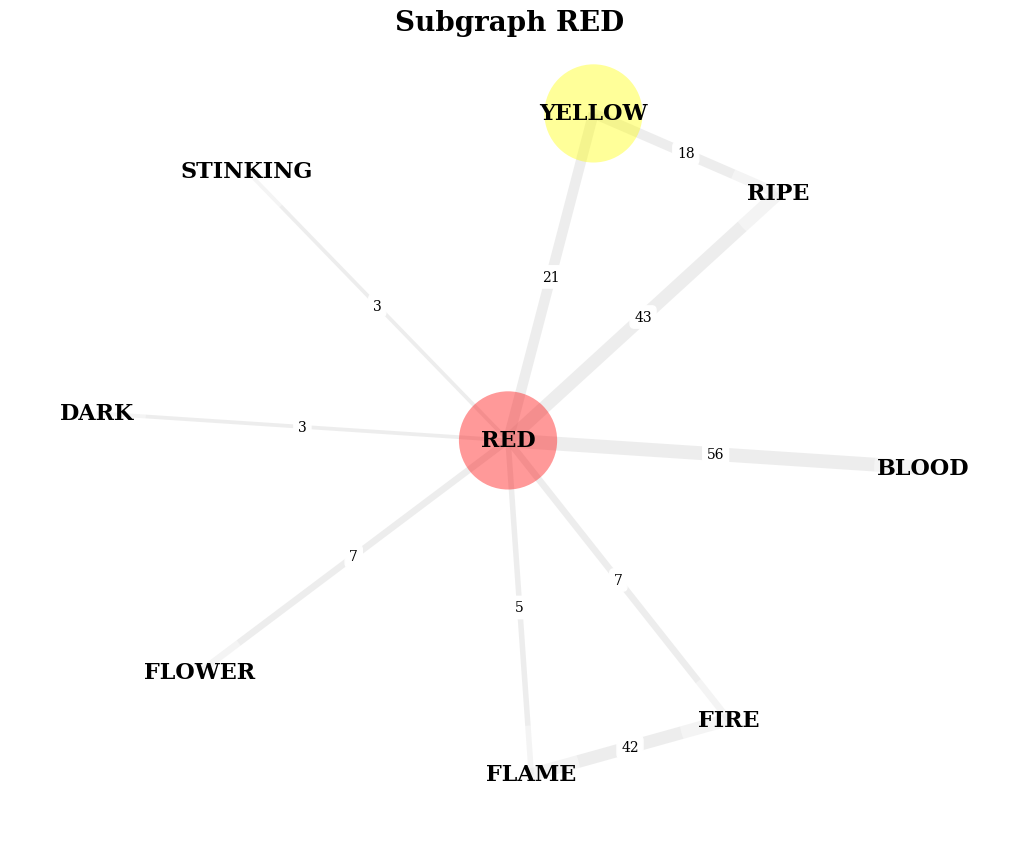

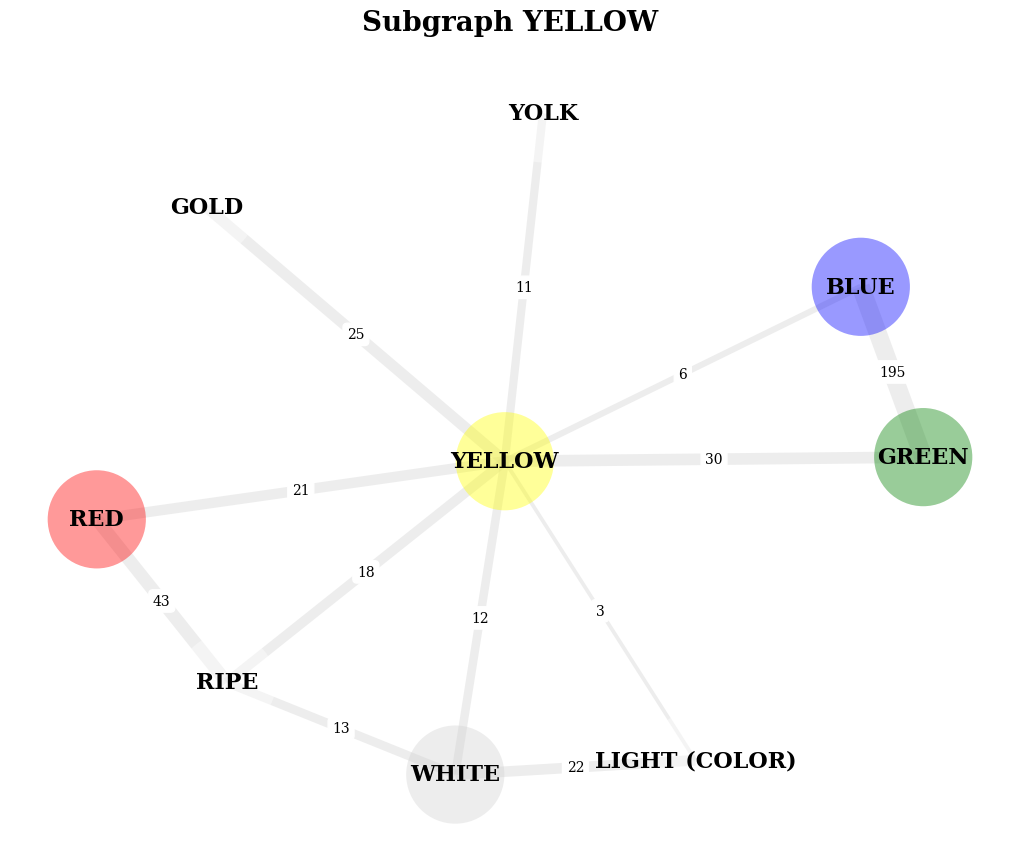

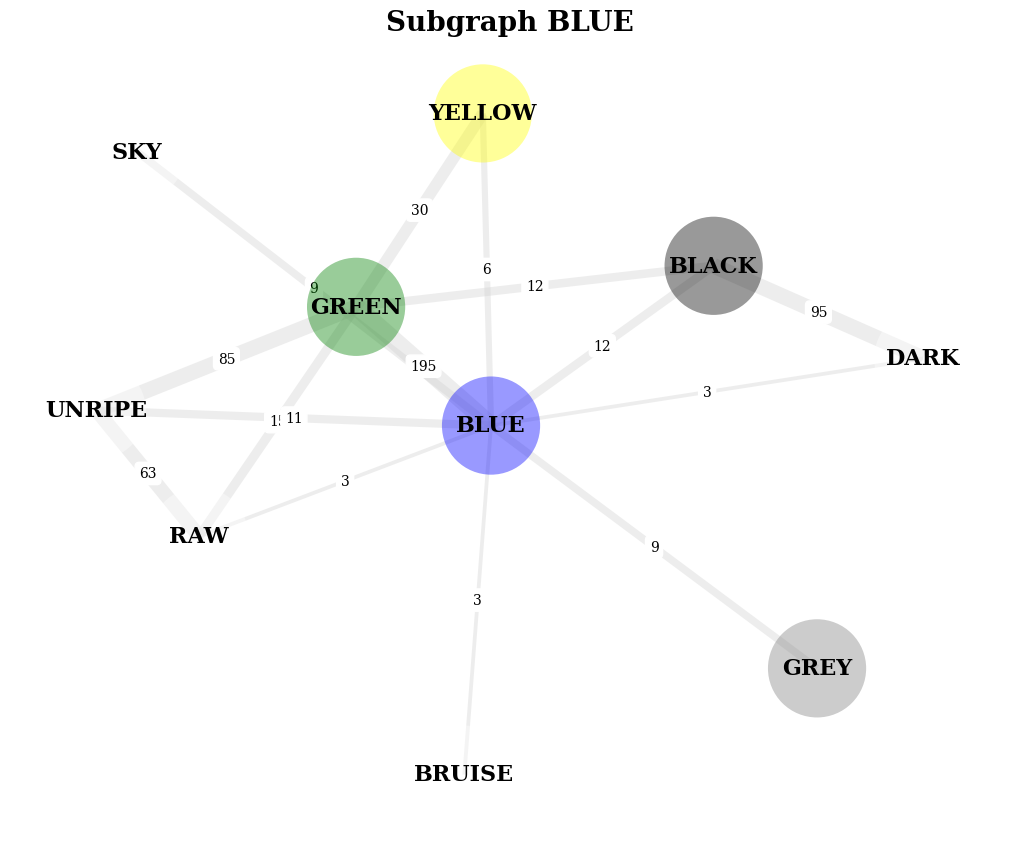

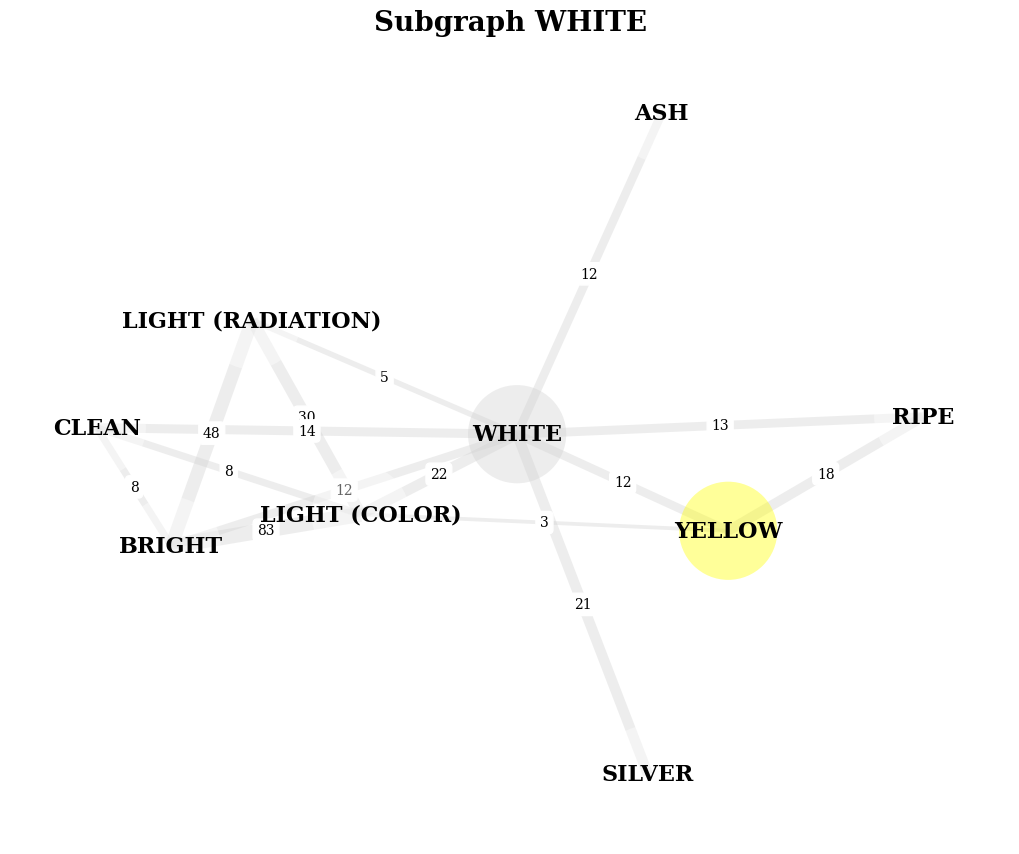

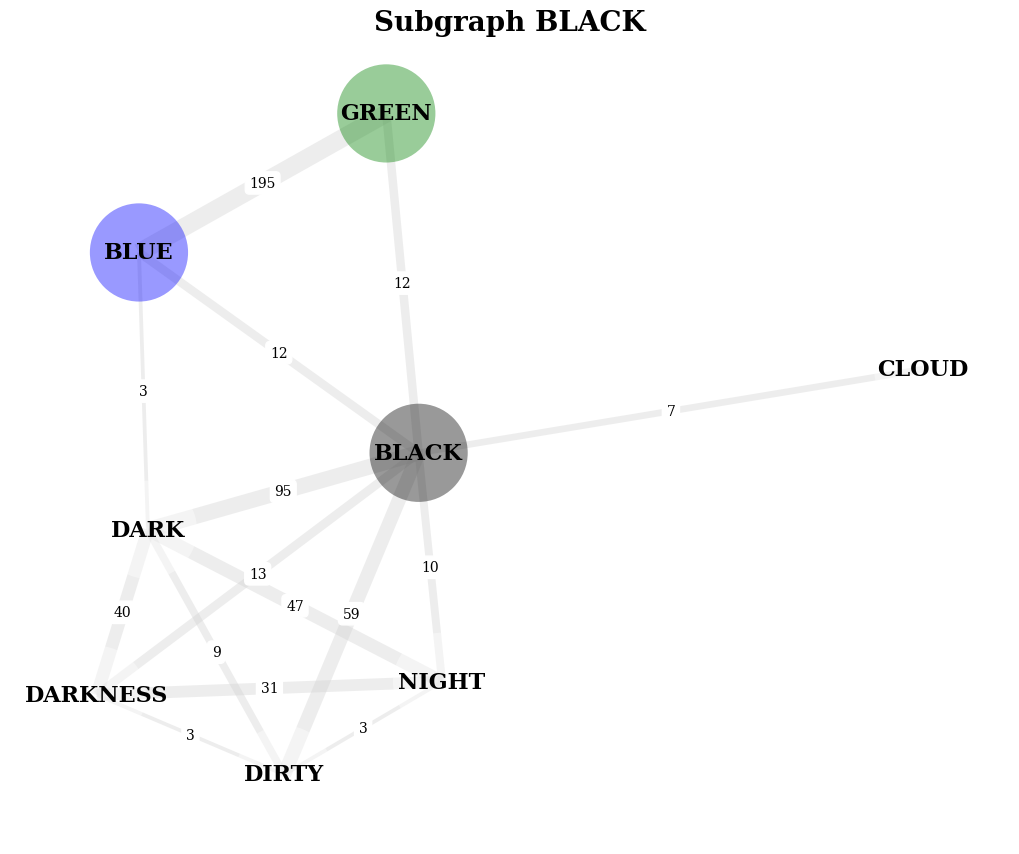

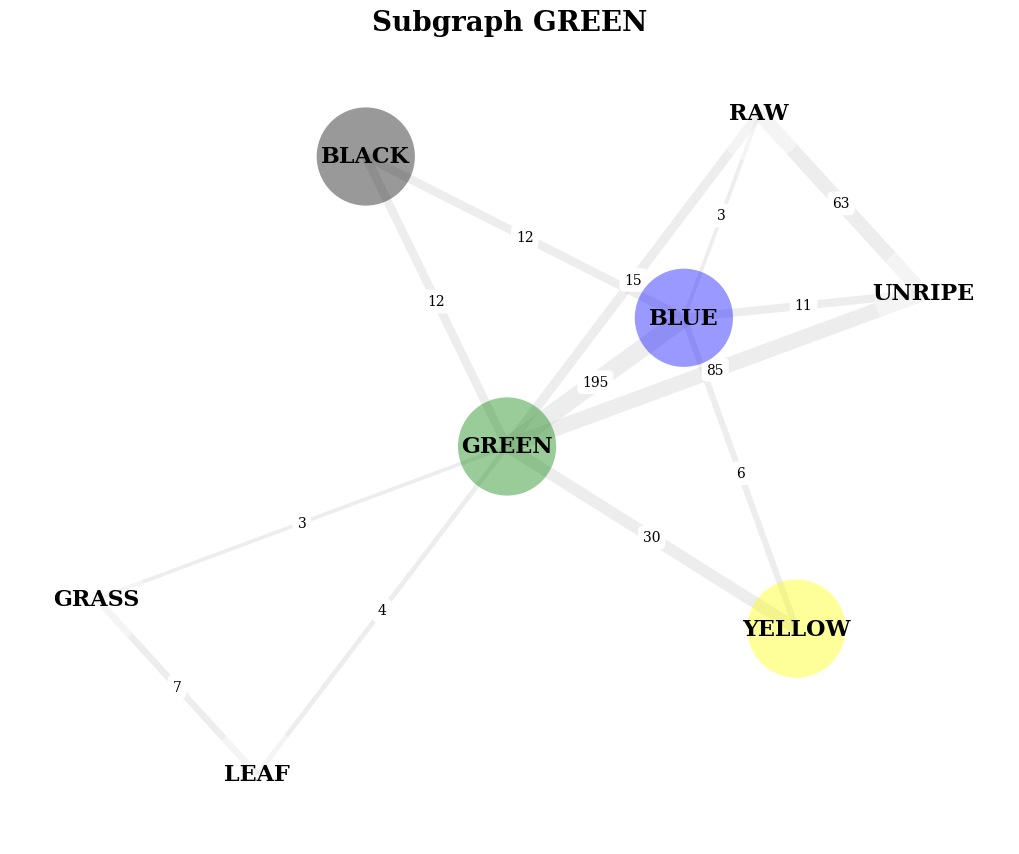

In [28]:
for node in cnodes[:6]:
    draw_subgraph(node)

In [29]:
def draw_all(g):

    colour_dict = {}
    node_size = {}
    noi = [str(n) for n in cnodes]

    for n in noi.copy():
        n = str(n)
        node_size[n] = 2* g.nodes[n]["LanguageFrequency"]
        colour_dict[n] = g.nodes[n]["Gloss"]
        neighbors = list(g.neighbors(n))
        noi = noi + neighbors

    subgraph = nx.induced_subgraph(g, noi).copy()

    subgraph.remove_edges_from([(u, v) for u, v in subgraph.edges() if u not in cnodes and v not in cnodes])

    colour_dict["1335"] = "lightgrey"
    colour_dict["3328"] = "orange"

    fixed_positions = {"3328": (92, 92), "2452": (80,100), "2409": (100,80)}

    # Draw the subgraph
    pos = nx.spring_layout(subgraph, scale=10000, iterations=10000, k=20)
    #pos = nx.kamada_kawai_layout(subgraph, scale=1000,)

    size_list = list(pd.Series(pos.keys()).replace(node_size))
    colour_list = list(pd.Series(pos.keys()).replace(colour_dict))

    def replace_intable(strings):
        for i in range(len(strings)):
            try:
                int(strings[i])
                strings[i] = "white"
            except ValueError:
                continue
        return strings

    colour_list = replace_intable(colour_list)

    for s in size_list.copy():
        if type(s) == str:
            size_list[size_list.index(s)] = 3000

    plt.figure(figsize=(14,14))

    labels = nx.get_node_attributes(subgraph, 'Gloss')
    edge_labels = nx.get_edge_attributes(subgraph, 'LanguageWeight')
    edge_widths = [math.log(subgraph[u][v]['LanguageWeight'], 1.25) for u, v in subgraph.edges()]

    nx.draw(subgraph, pos, font_family="serif",  edge_color='lightgrey', width=edge_widths, node_size=size_list, node_color=colour_list, alpha=0.4, linewidths=0)

    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_family="serif",  font_weight='bold')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_family="serif", rotate=False)

    plt.title("Colour Colexifications", fontdict={'fontsize': 24, 'fontweight': 'bold', 'fontname': 'serif'})
    plt.savefig("plots/colour_colexifications.png", bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

    return subgraph

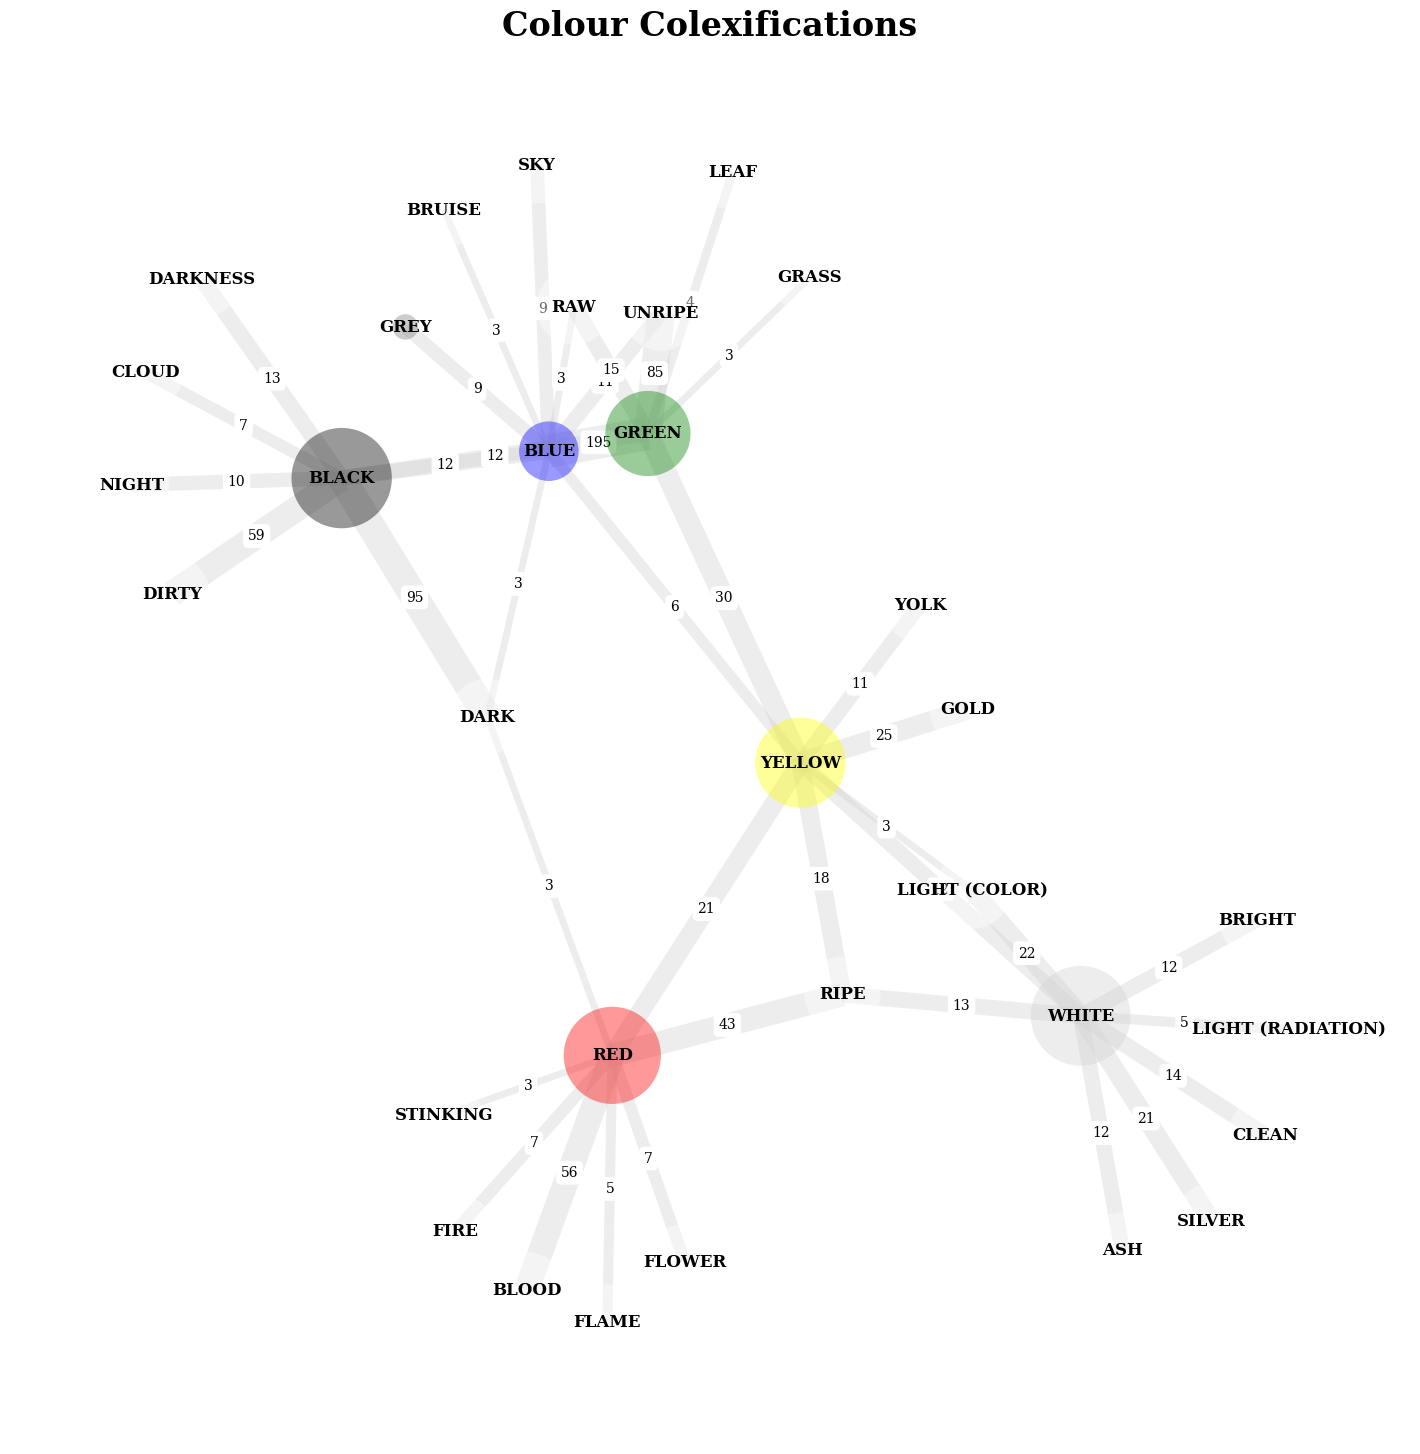

In [43]:
reduced = draw_all(g)

In [44]:
def calc_weights(fam, g):
    langs = nx.get_edge_attributes(g, 'languages')
    
    for e in g.edges():
        edge_langs = [l.split("-")[-1] for l in langs[e].split(";")]
        weights = Counter(pd.Series(edge_langs).map(lambda x: fam_dict.get(x,x)))
        g.edges[e]["FamilyWeight"] = weights[fam]

    return g

In [45]:
langs = nx.get_edge_attributes(g, "languages")
formatted_langs = ([l.split("-")[-1] for l in ";".join(list(langs.values())).split(";")])
fam_counter = Counter(pd.Series(formatted_langs).replace(fam_dict))
fam_counter.most_common(10)

[('Nakh-Daghestanian', 12092),
 ('Indo-European', 9938),
 ('Austronesian', 4835),
 ('Uralic', 4438),
 ('Sino-Tibetan', 3498),
 ('Atlantic-Congo', 3235),
 ('Tai-Kadai', 2616),
 ('Austroasiatic', 2572),
 ('Turkic', 2445),
 ('Nuclear Trans New Guinea', 1950)]

In [46]:
def trim_graph(g):
    
    g.remove_edges_from([(u, v) for u, v, data in g.edges(data=True) if data['FamilyWeight'] == 0])

    g.remove_edges_from([(u, v) for u, v in g.edges() if u not in cnodes and v not in cnodes])

    g.remove_nodes_from(list(nx.isolates(g)))

    return g

In [47]:
def graph_by_family(g, fam="Indo-European"):
    
    sg = calc_weights(fam, g)
    
    subg = sg.copy()

    colour_dict = {}
    node_size = {}
    noi = [str(n) for n in cnodes]

    for n in noi.copy():
        colour_dict[n] = subg.nodes[n]["Gloss"]
    
    subg = trim_graph(subg)

    graph_splits = [subg.subgraph(c).copy() for c in nx.connected_components(subg)]

    if len(graph_splits) == 1:
        pos = nx.spring_layout(subg, scale=1000, k=5, iterations=1000)
    else:
        pos = nx.spring_layout(subg, iterations=40, k=0.7)

    colour_list = list(pd.Series(pos.keys()).replace(colour_dict))

    def replace_colours(strings):
        r = []
        for s in strings:
            if s == "WHITE":
                r.append("lightgrey")
            elif s in c:
                r.append(s)
            else:
                r.append("white")
        return r

    colour_list = replace_colours(colour_list)

    labels = nx.get_node_attributes(subg, 'Gloss')
    edge_labels = nx.get_edge_attributes(subg, 'FamilyWeight')
    edge_widths = [max(1, math.log(subg[u][v]['FamilyWeight'], 1.25)) if subg[u][v]['FamilyWeight'] > 0 else 1 for u, v in subg.edges()]

    plt.figure(figsize=(18,10))

    nx.draw(subg, pos, font_family="serif",  edge_color='lightgrey', width=edge_widths, node_color=colour_list, alpha=0.4, linewidths=0, node_size=6000)

    nx.draw_networkx_labels(subg, pos, labels=labels, font_family="serif",  font_weight='bold', font_size=16)
    nx.draw_networkx_edge_labels(subg, pos, edge_labels=edge_labels, font_family="serif", rotate=False, font_size=16)

    plt.title("Colour Colexifications in "+fam+" Languages", fontdict={'fontsize': 28, 'fontweight': 'bold', 'fontname': 'serif'})
    plt.savefig("plots/" + fam + ".png", bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()

    return subg

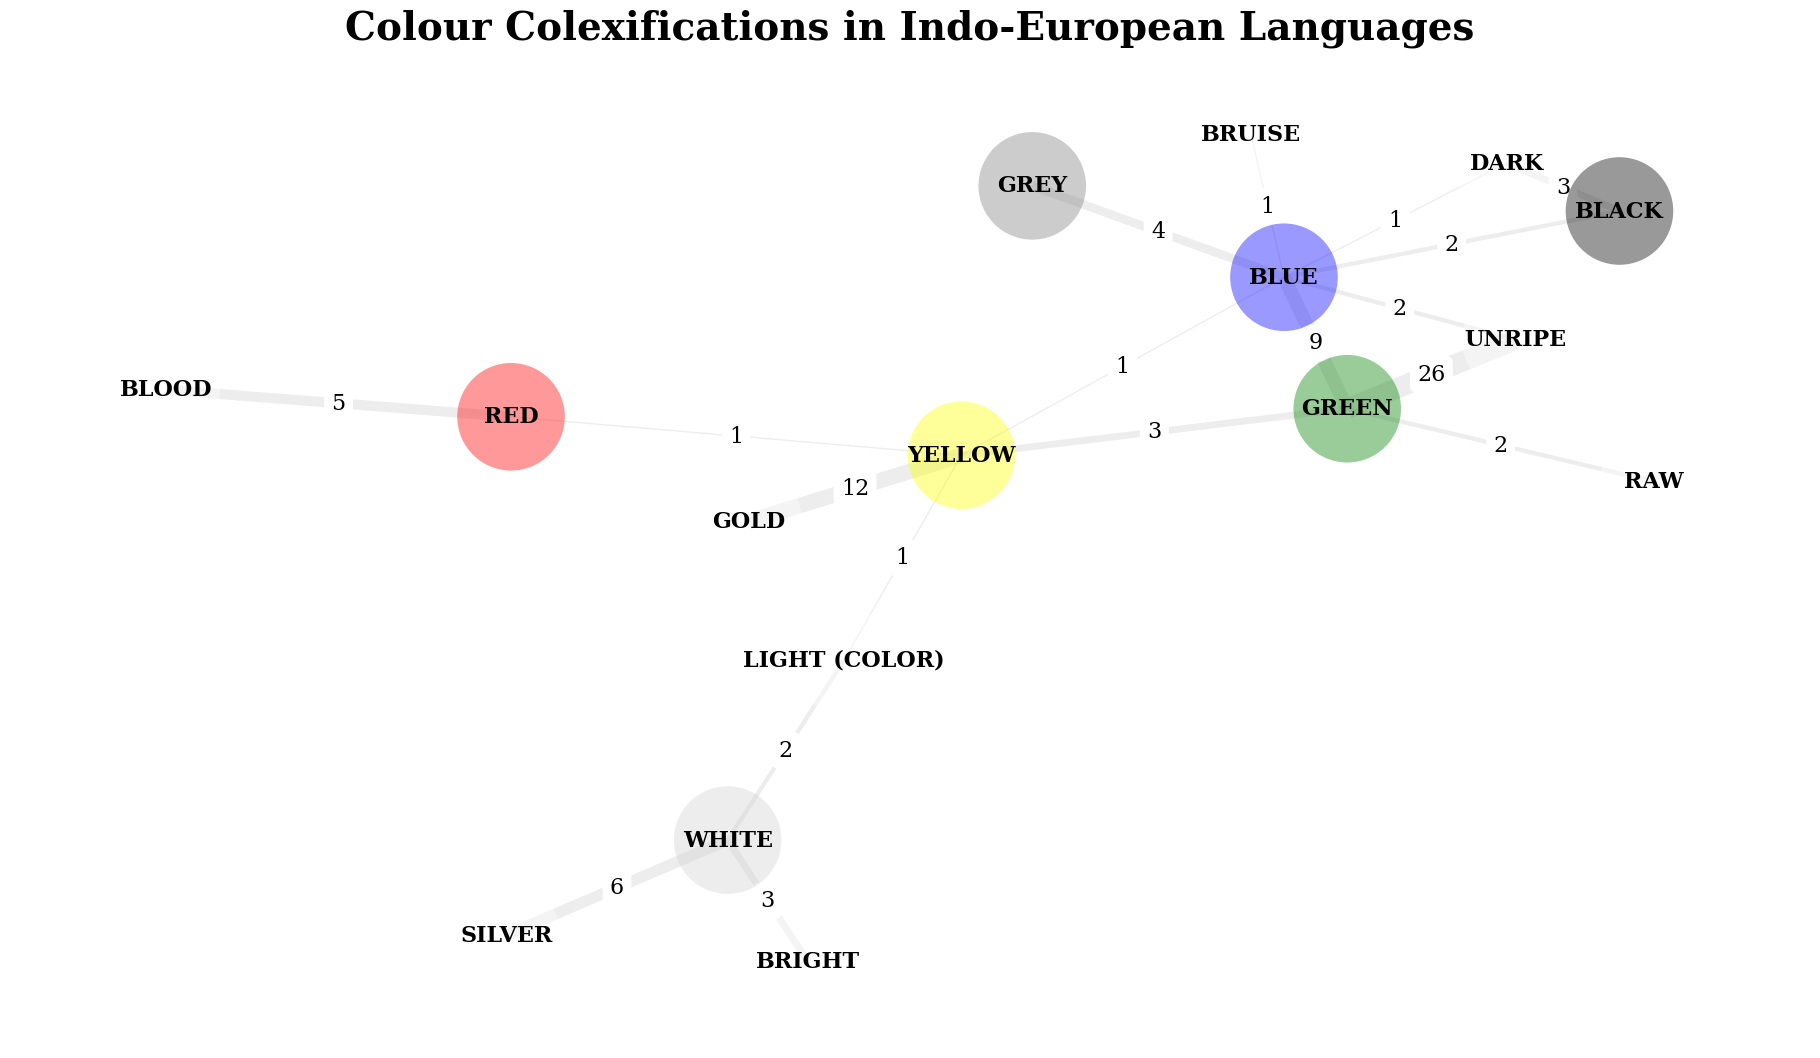

['156', '1424', '837', '1335', '163', '1425', '153']
Indo-European {'RED': 6, 'YELLOW': 18, 'BLUE': 20, 'WHITE': 11, 'BLACK': 5, 'GREEN': 40, 'GREY': 4}


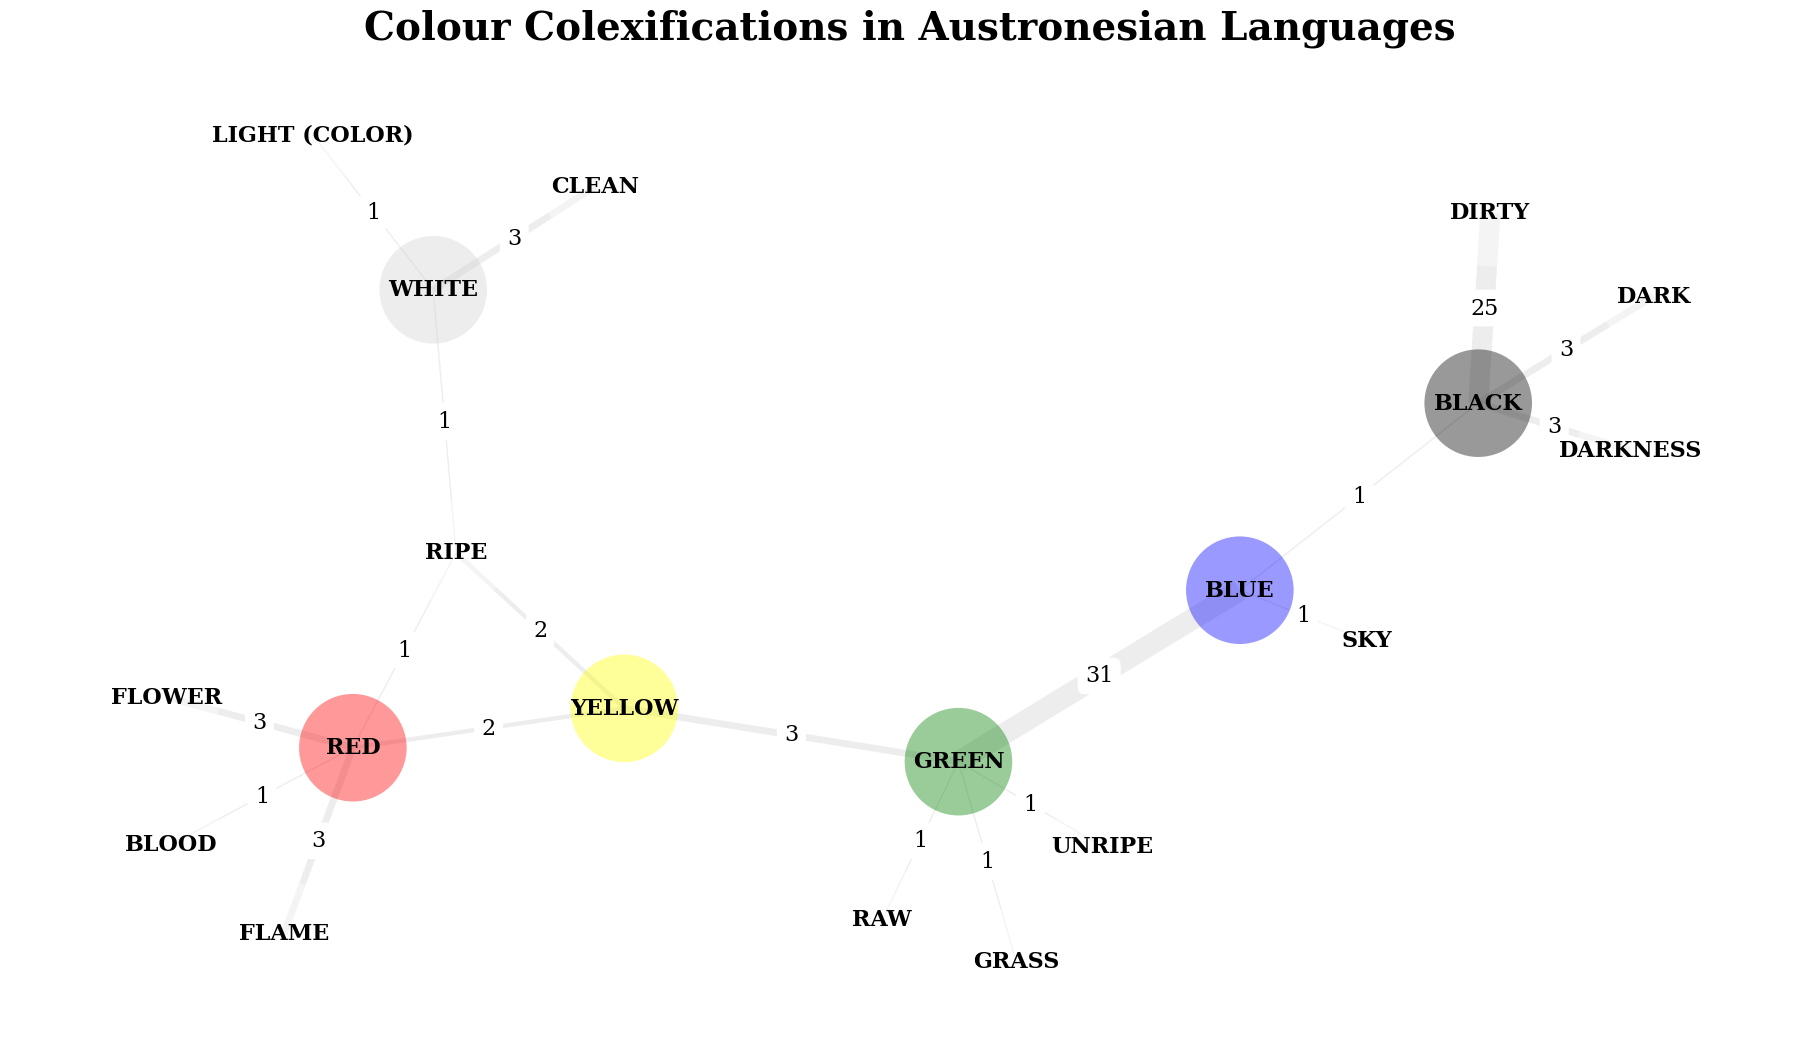

['156', '1424', '837', '1335', '163', '1425', '153']
Austronesian {'RED': 10, 'YELLOW': 7, 'BLUE': 33, 'WHITE': 5, 'BLACK': 32, 'GREEN': 37}


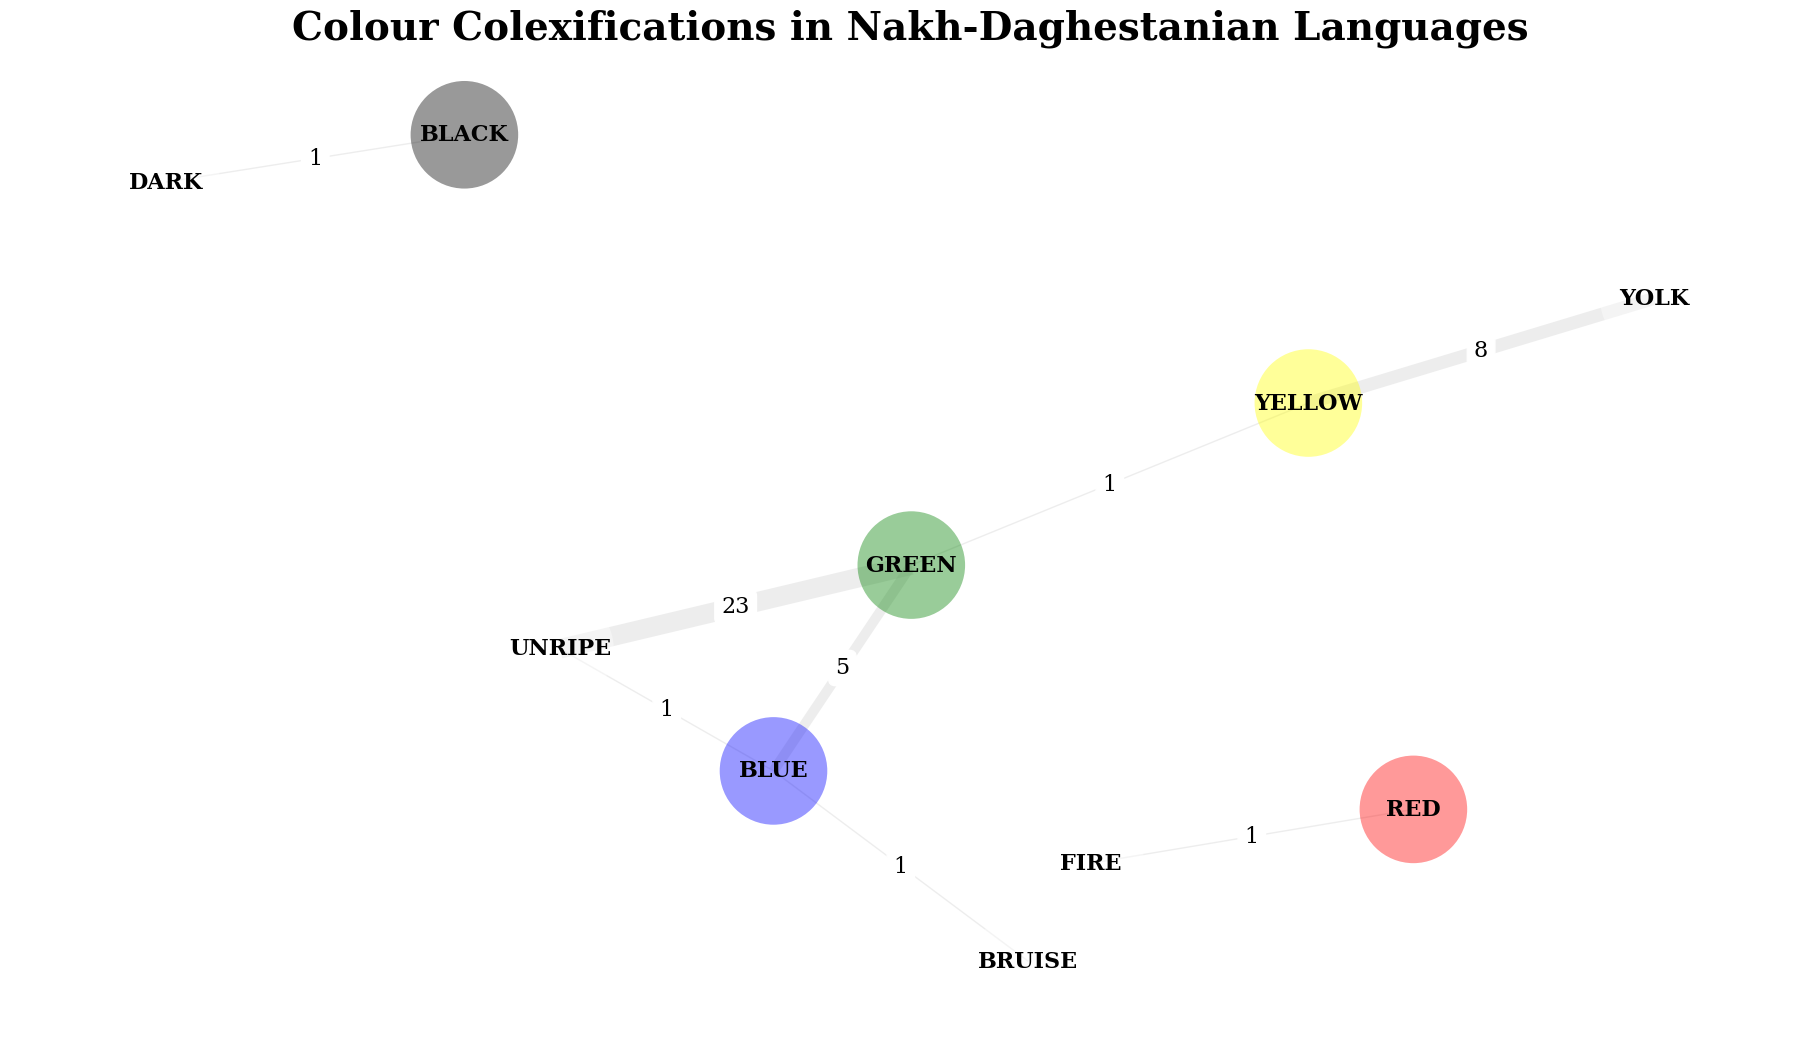

['156', '1424', '837', '1335', '163', '1425', '153']
Nakh-Daghestanian {'RED': 1, 'YELLOW': 9, 'BLUE': 7, 'BLACK': 1, 'GREEN': 29}


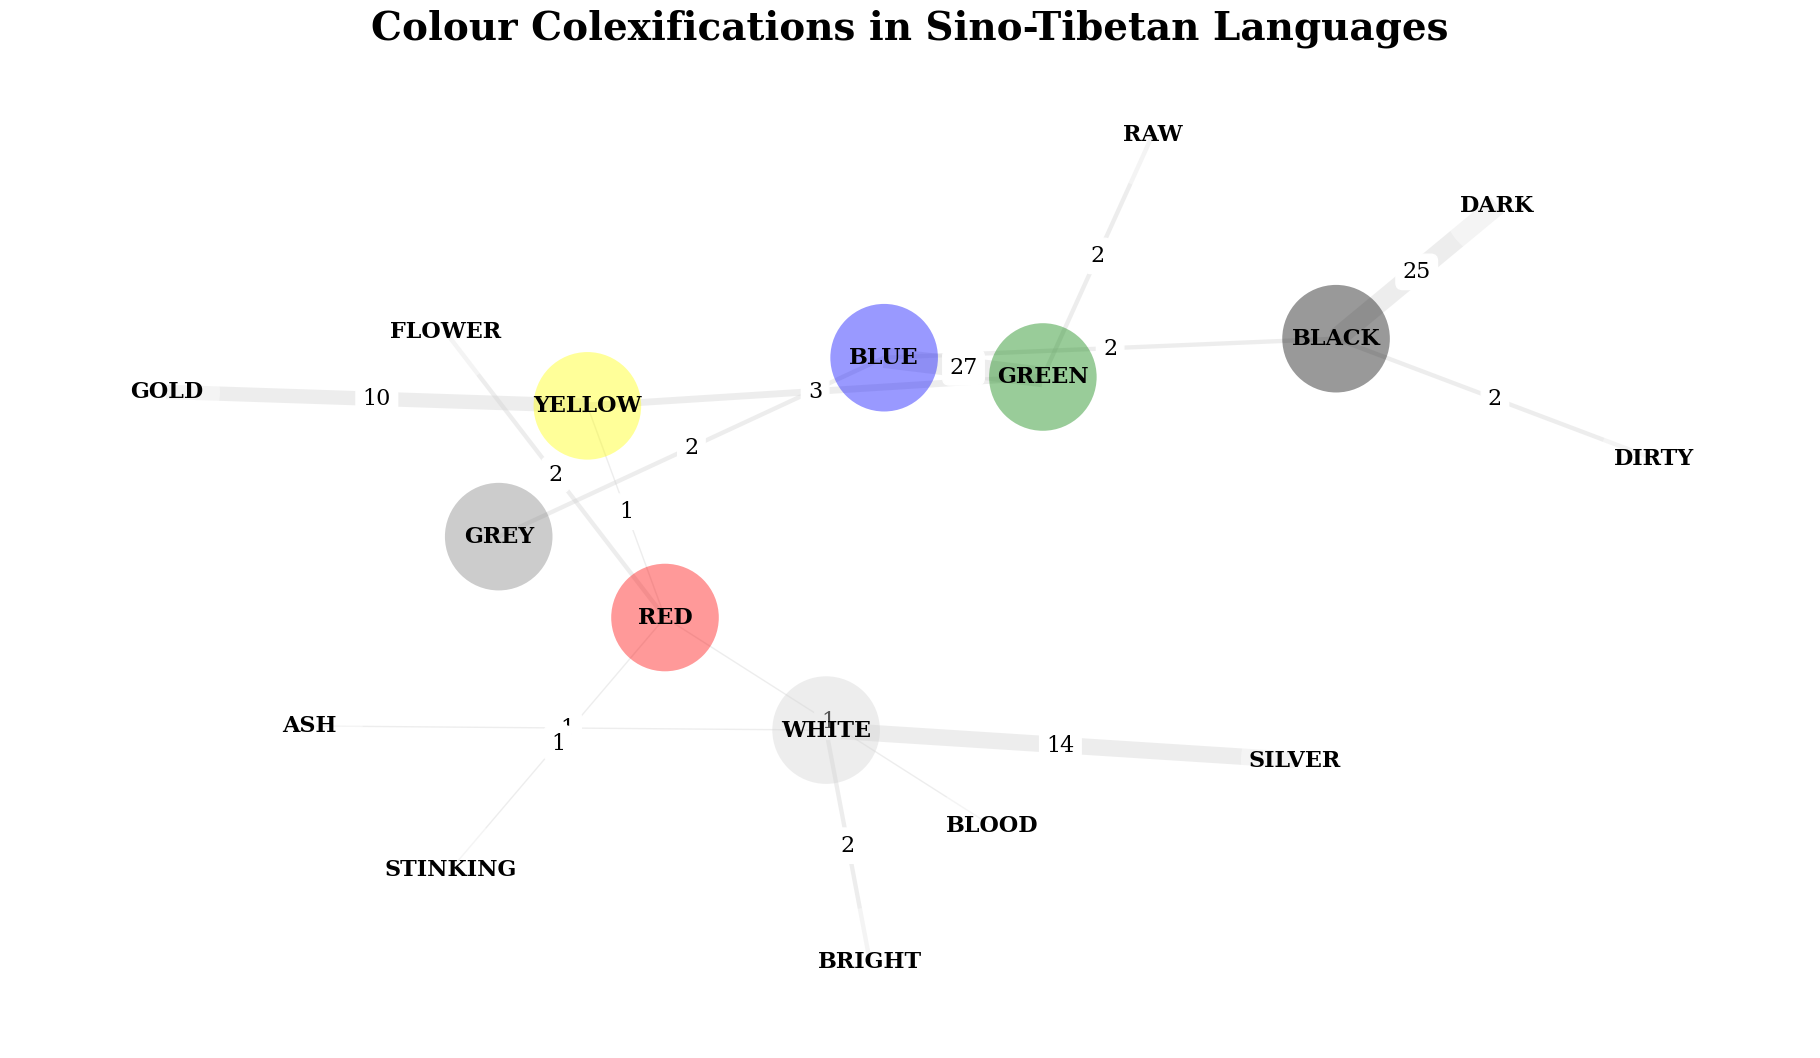

['156', '1424', '837', '1335', '163', '1425', '153']
Sino-Tibetan {'RED': 5, 'YELLOW': 14, 'BLUE': 31, 'WHITE': 17, 'BLACK': 29, 'GREEN': 32, 'GREY': 2}


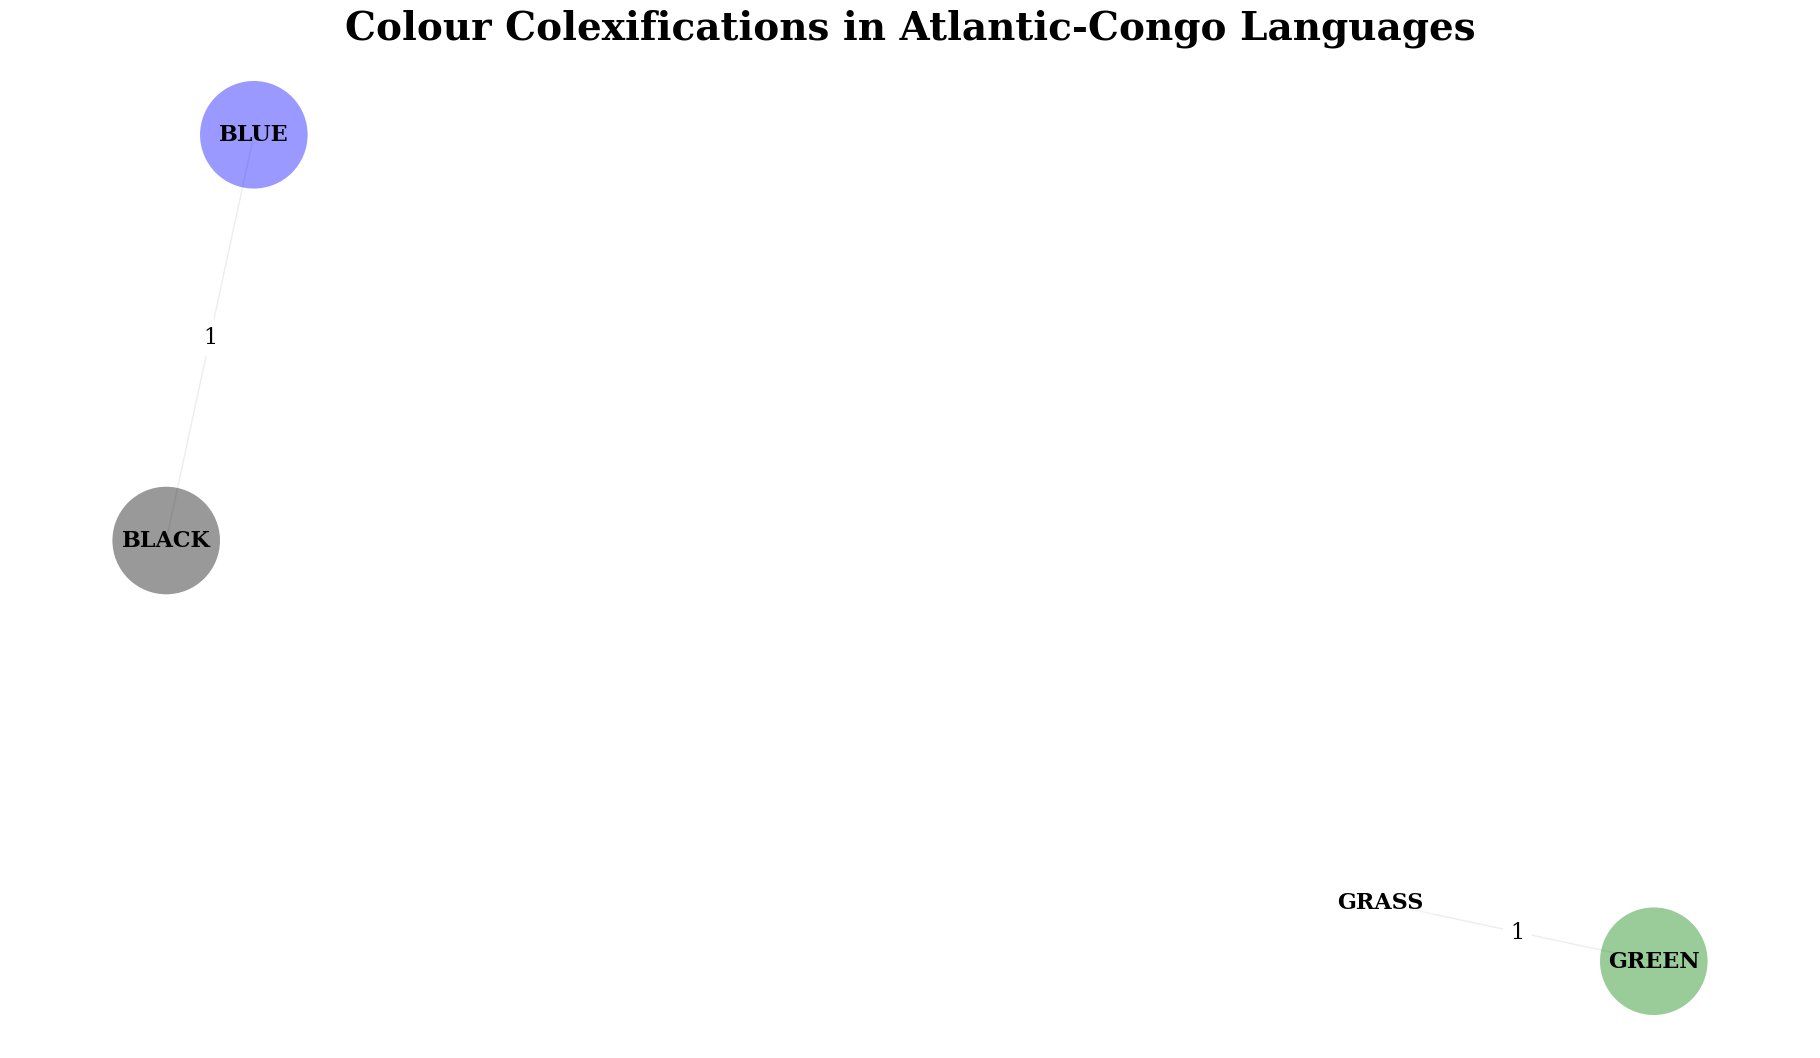

['156', '1424', '837', '1335', '163', '1425', '153']
Atlantic-Congo {'BLUE': 1, 'BLACK': 1, 'GREEN': 1}


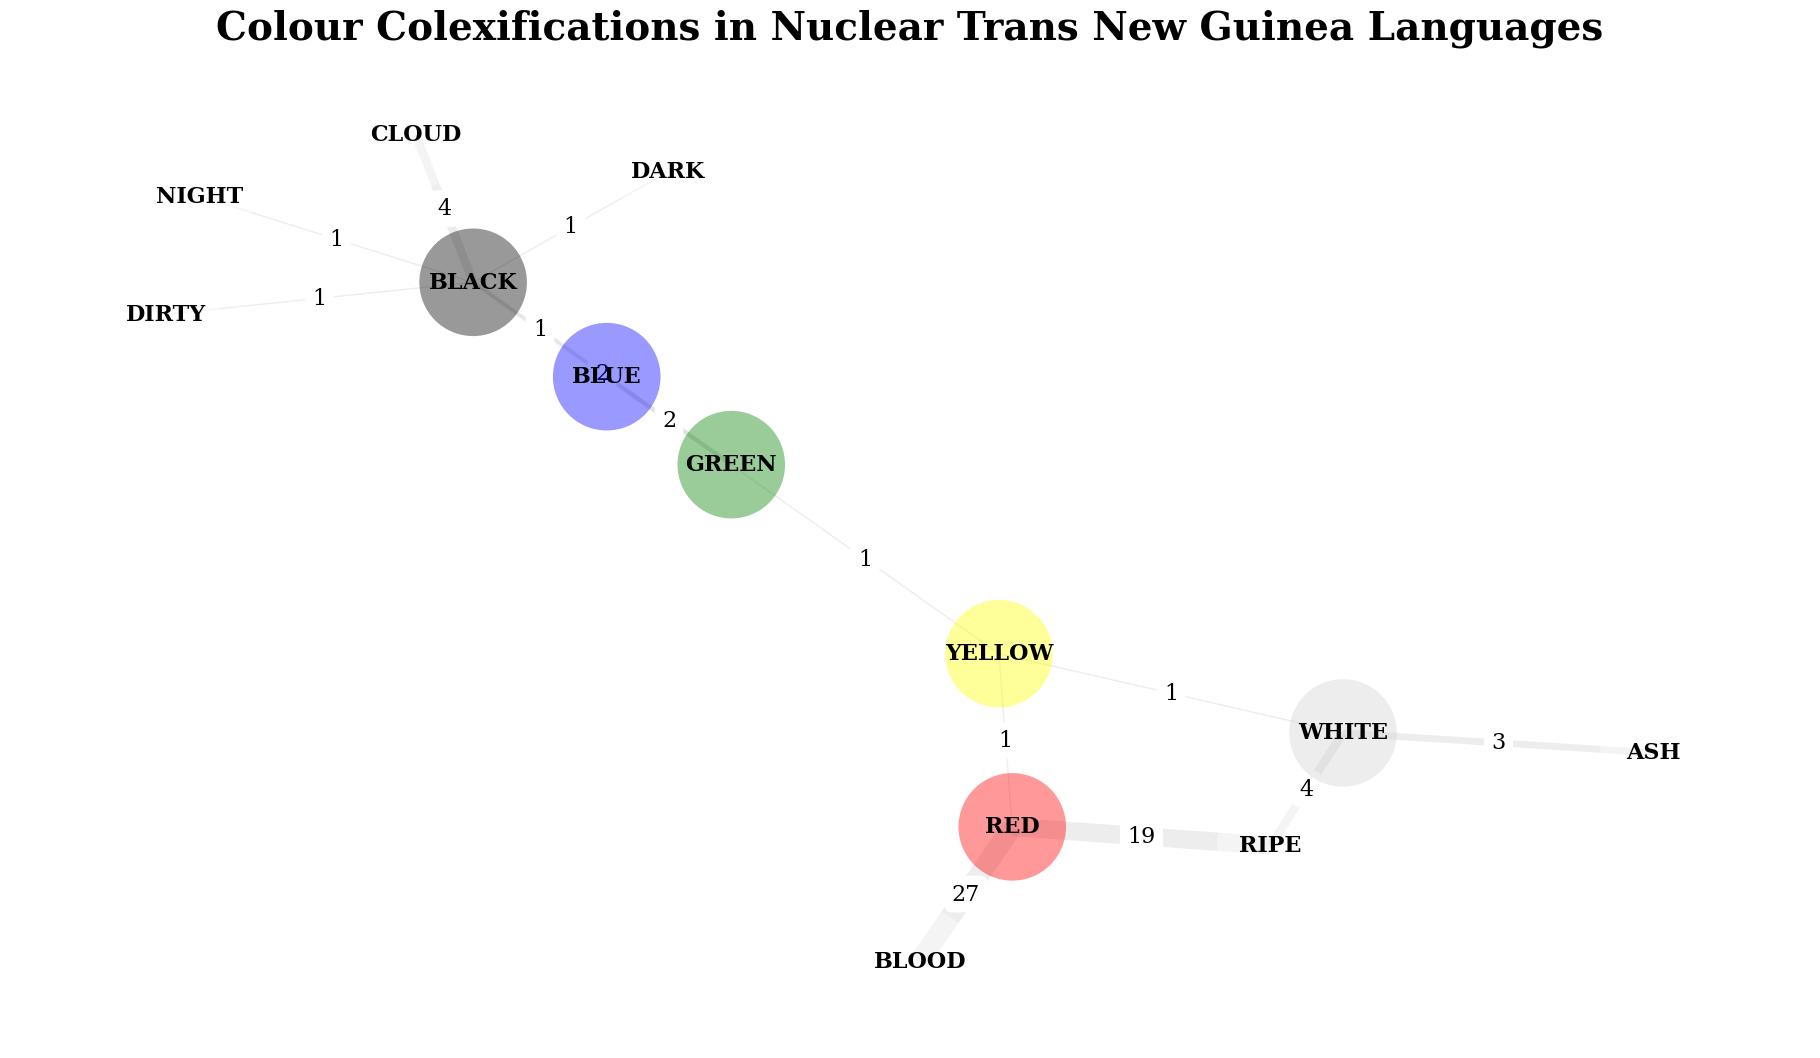

['156', '1424', '837', '1335', '163', '1425', '153']
Nuclear Trans New Guinea {'RED': 47, 'YELLOW': 3, 'BLUE': 3, 'WHITE': 8, 'BLACK': 10, 'GREEN': 5}


In [48]:
lang_sums = {}
for fam in ["Indo-European", "Austronesian", "Nakh-Daghestanian", "Sino-Tibetan", "Atlantic-Congo", "Nuclear Trans New Guinea"]:
    s = graph_by_family(reduced, fam)
    colour_weights = {}
    print(cnodes)
    for cnode in cnodes:
        colour_weight_sum = 0
        if cnode in s.nodes:
            for neighbor in list(s.neighbors(cnode)):
                colour_weight_sum += s.edges[cnode, neighbor]['FamilyWeight']
            colour_weights[s.nodes[cnode]["Gloss"]] = colour_weight_sum

    print(fam, colour_weights)
    lang_sums[fam] = colour_weights

In [49]:
from collections import defaultdict

grouped_dict = defaultdict(list)
for key, value in fam_dict.items():
    grouped_dict[value].append(key)

swapped_dict = dict(grouped_dict)
count = {key: len(value) for key, value in swapped_dict.items()}
language_count = {k: v for k, v in sorted(count.items(), key=lambda item: item[1], reverse=True)}
language_count

{'Austronesian': 547,
 'Nuclear Trans New Guinea': 462,
 'Indo-European': 266,
 'Sino-Tibetan': 223,
 'Pama-Nyungan': 175,
 'Atlantic-Congo': 155,
 'Nakh-Daghestanian': 107,
 'Timor-Alor-Pantar': 96,
 None: 83,
 'Afro-Asiatic': 74,
 'Uralic': 41,
 'Tai-Kadai': 41,
 'Austroasiatic': 39,
 'Lakes Plain': 32,
 'Nuclear Torricelli': 28,
 'Eastern Trans-Fly': 28,
 'Turkic': 27,
 'Lower Sepik-Ramu': 27,
 'Hmong-Mien': 26,
 "South Bird's Head Family": 22,
 'Tucanoan': 21,
 'Tupian': 21,
 'Sepik': 21,
 'Arawakan': 19,
 'Anim': 19,
 'Dogon': 16,
 'Pano-Tacanan': 15,
 'Ndu': 13,
 'Mailuan': 13,
 'Angan': 12,
 'Kiwaian': 12,
 "East Bird's Head": 12,
 'Eleman': 11,
 'Manubaran': 10,
 'Koiarian': 10,
 'East Strickland': 10,
 'Chocoan': 9,
 'Chapacuran': 9,
 'Bosavi': 9,
 'Chibchan': 8,
 'Cariban': 8,
 'Barbacoan': 7,
 'Abkhaz-Adyge': 7,
 'West Bomberai': 7,
 'Tor-Orya': 7,
 'Nuclear-Macro-Je': 6,
 'Dravidian': 6,
 'Kartvelian': 6,
 'Left May': 6,
 'Piawi': 6,
 'Border': 6,
 'Guahiboan': 5,
 'Matacoa

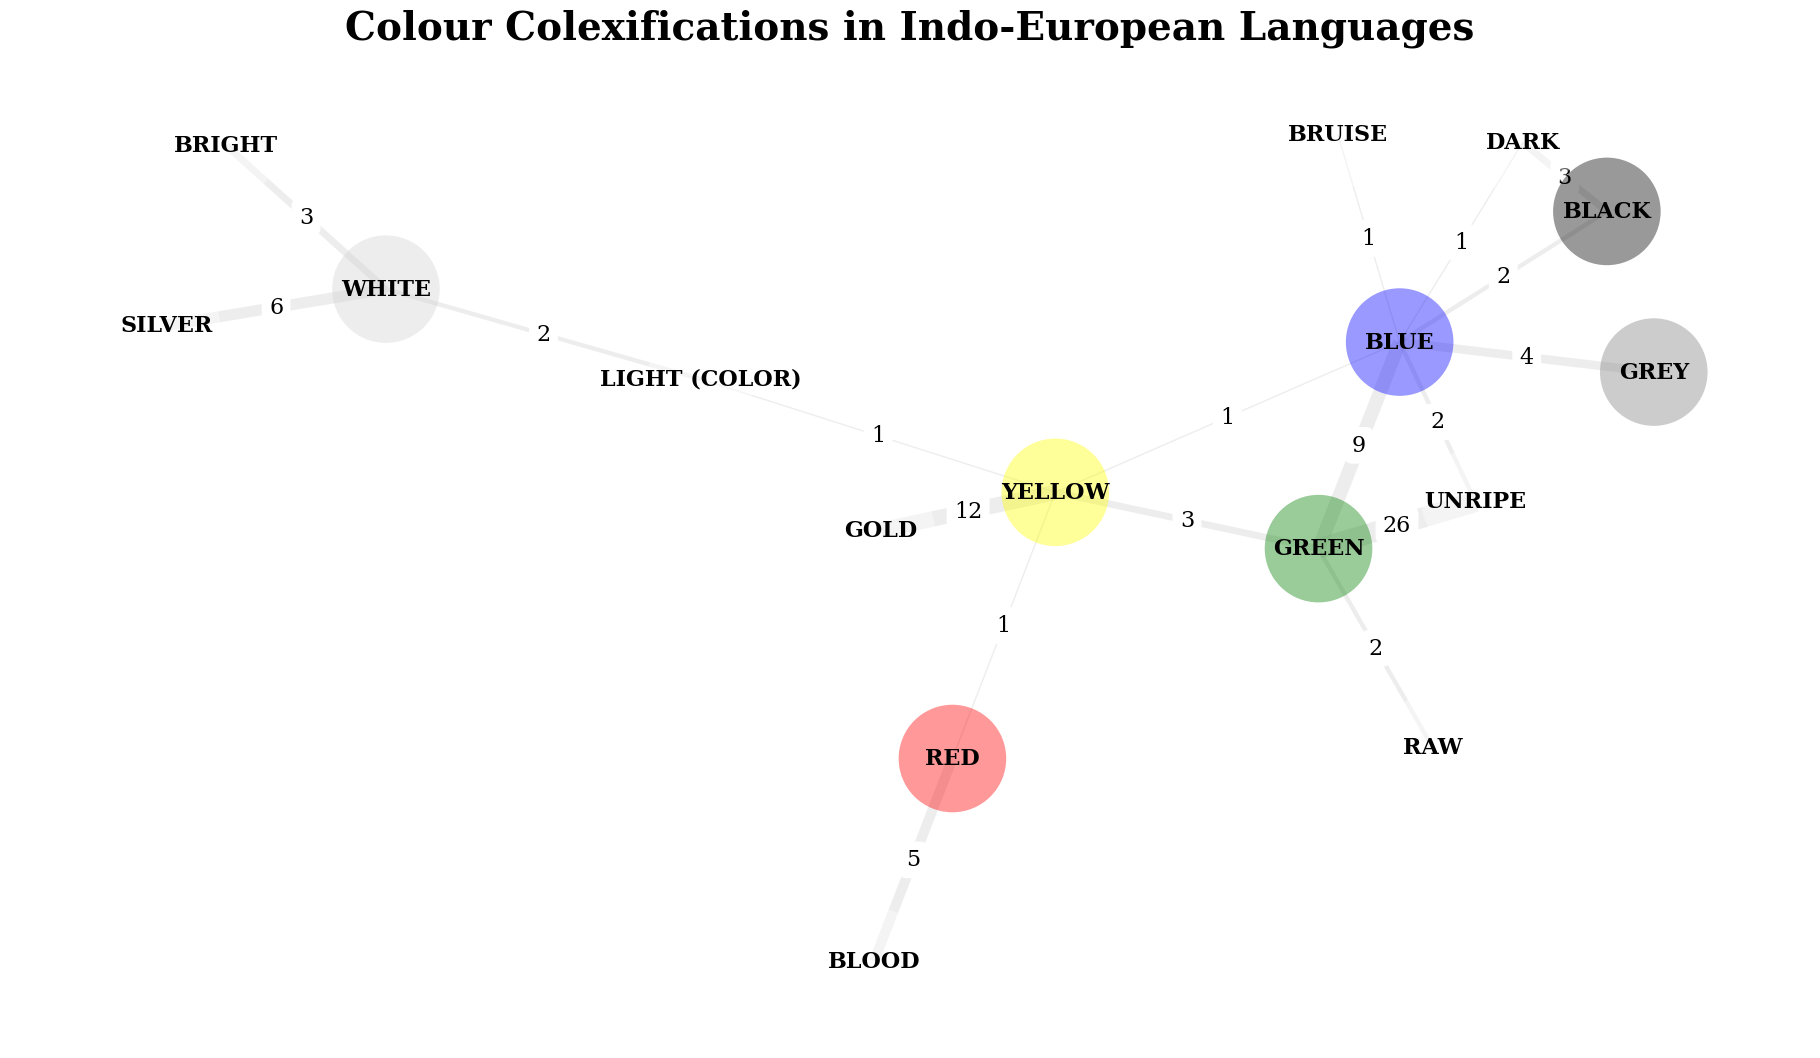

Indo-European 84 9938


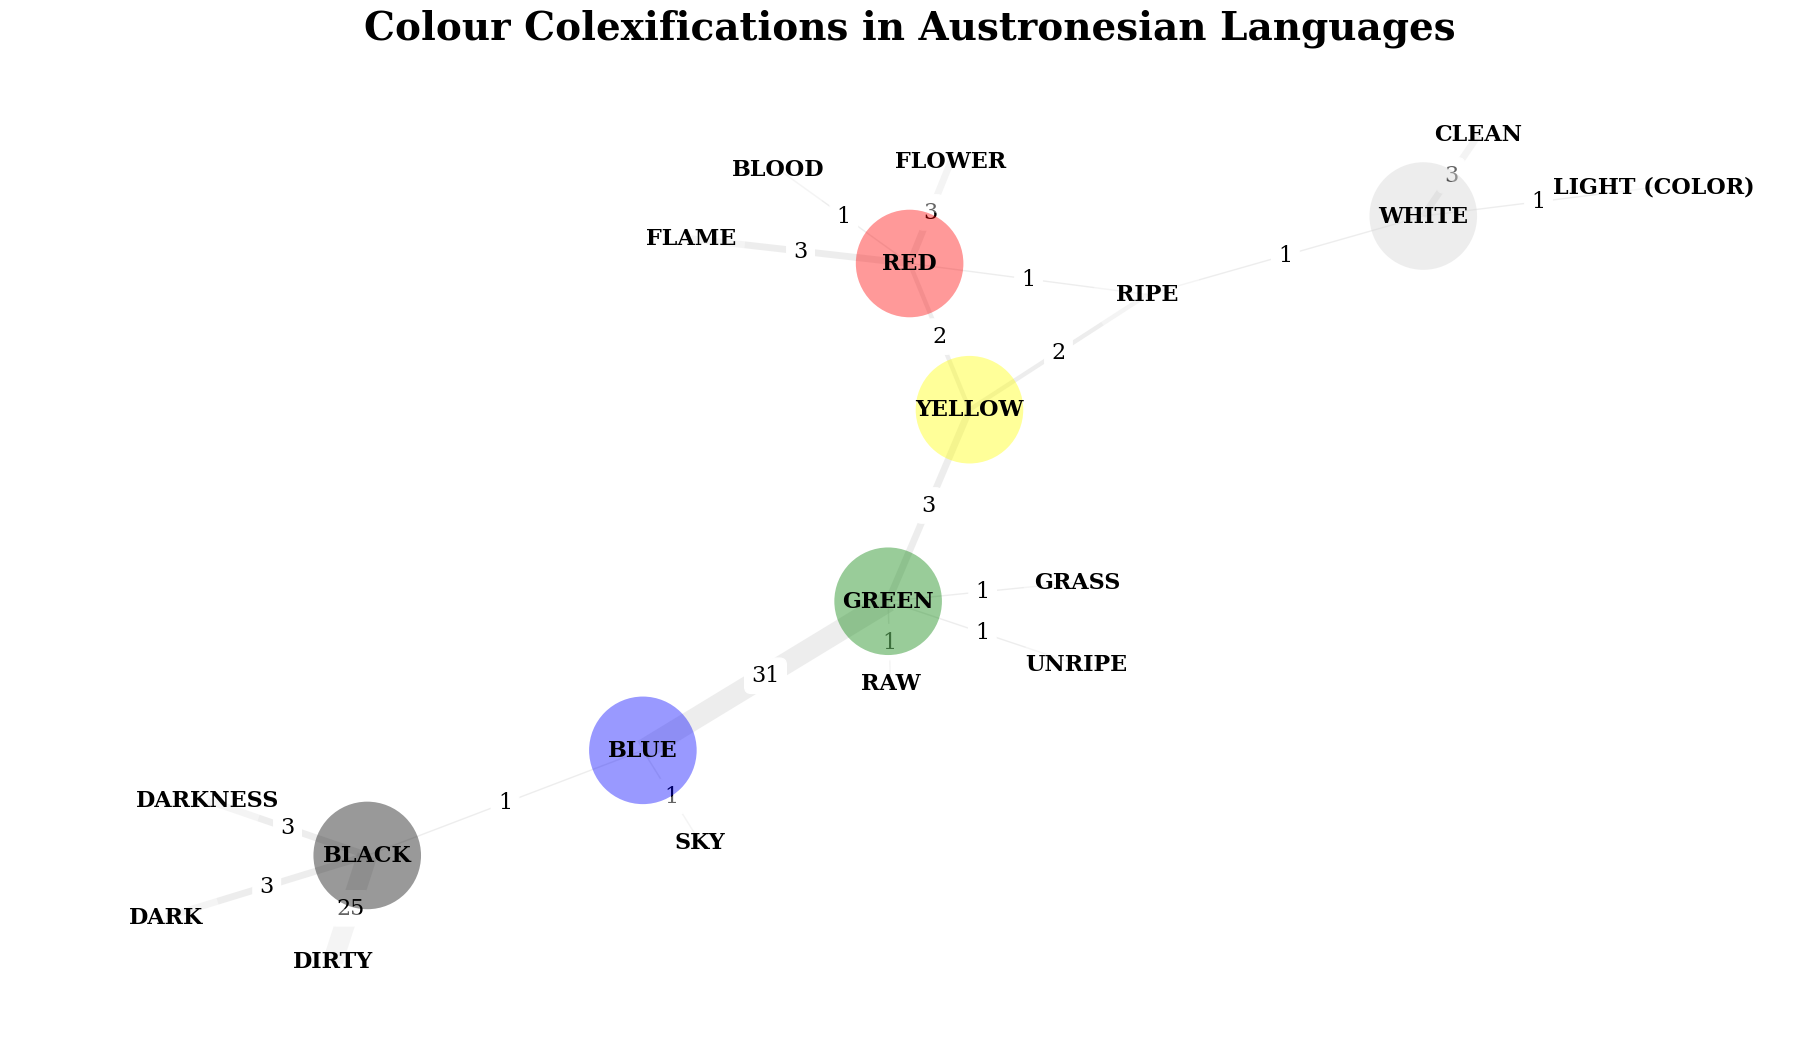

Austronesian 87 4835


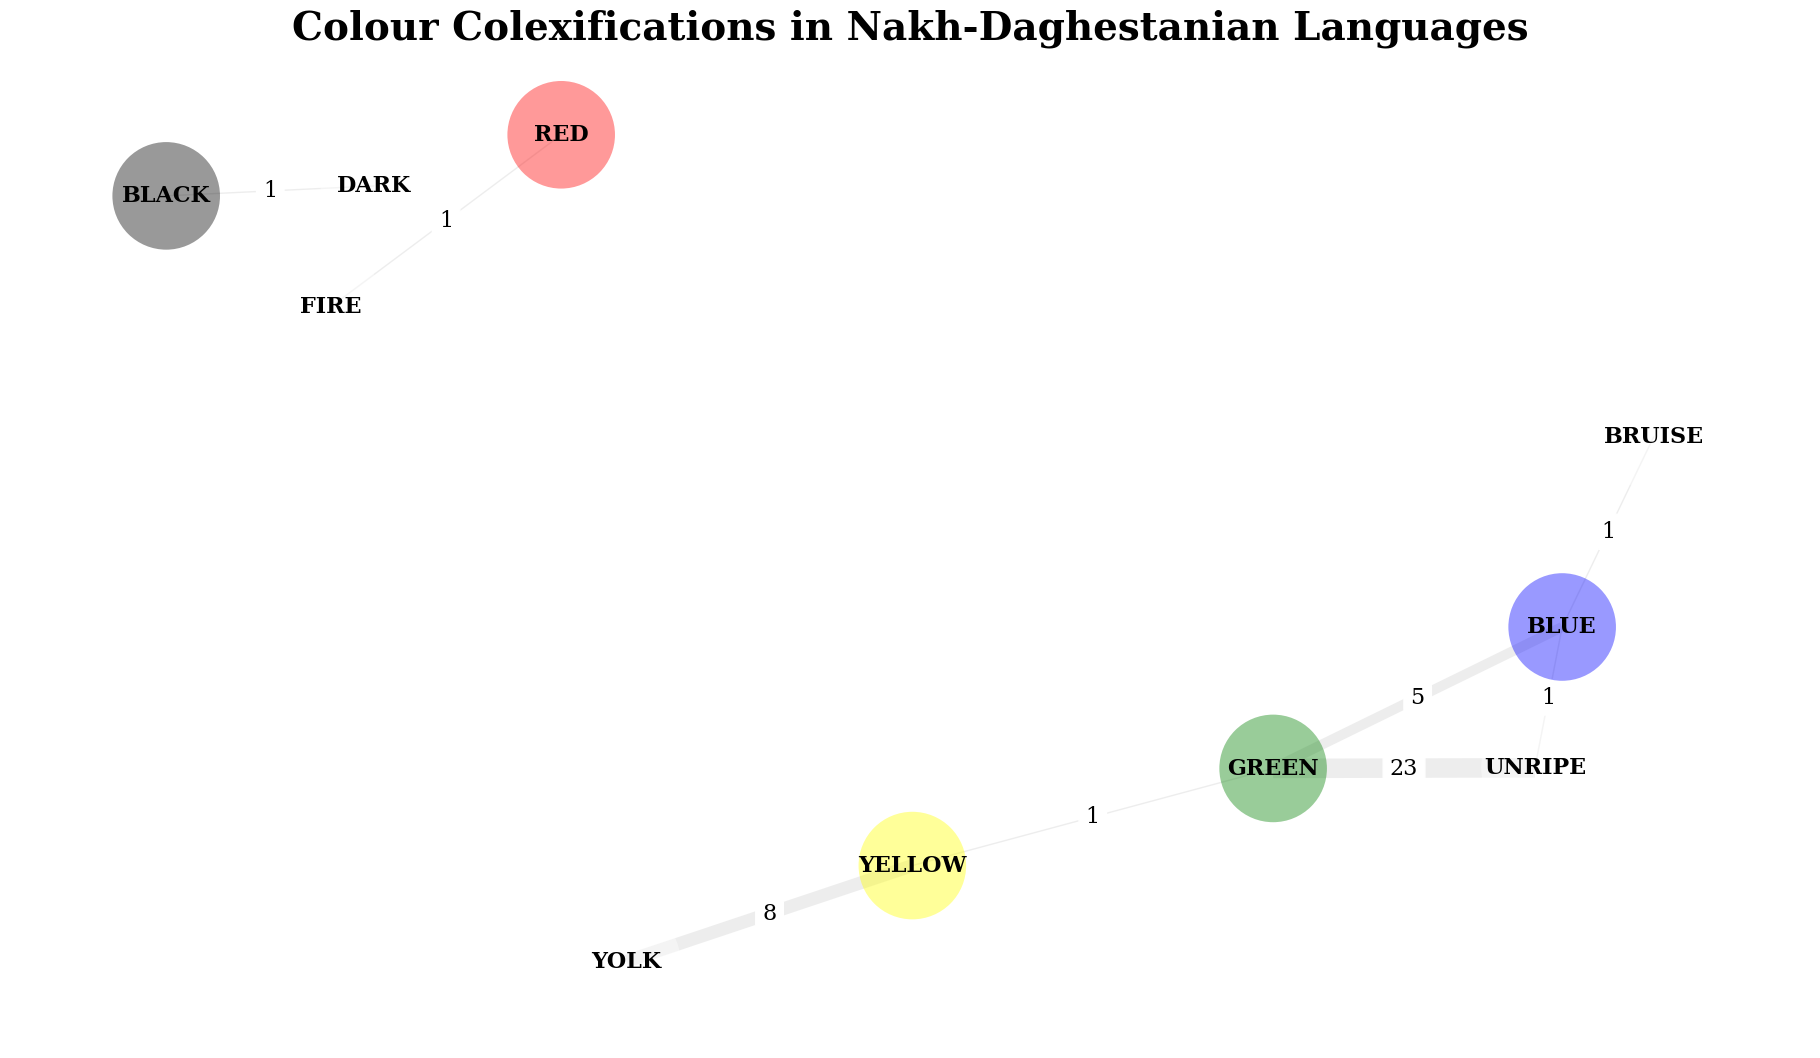

Nakh-Daghestanian 41 12092


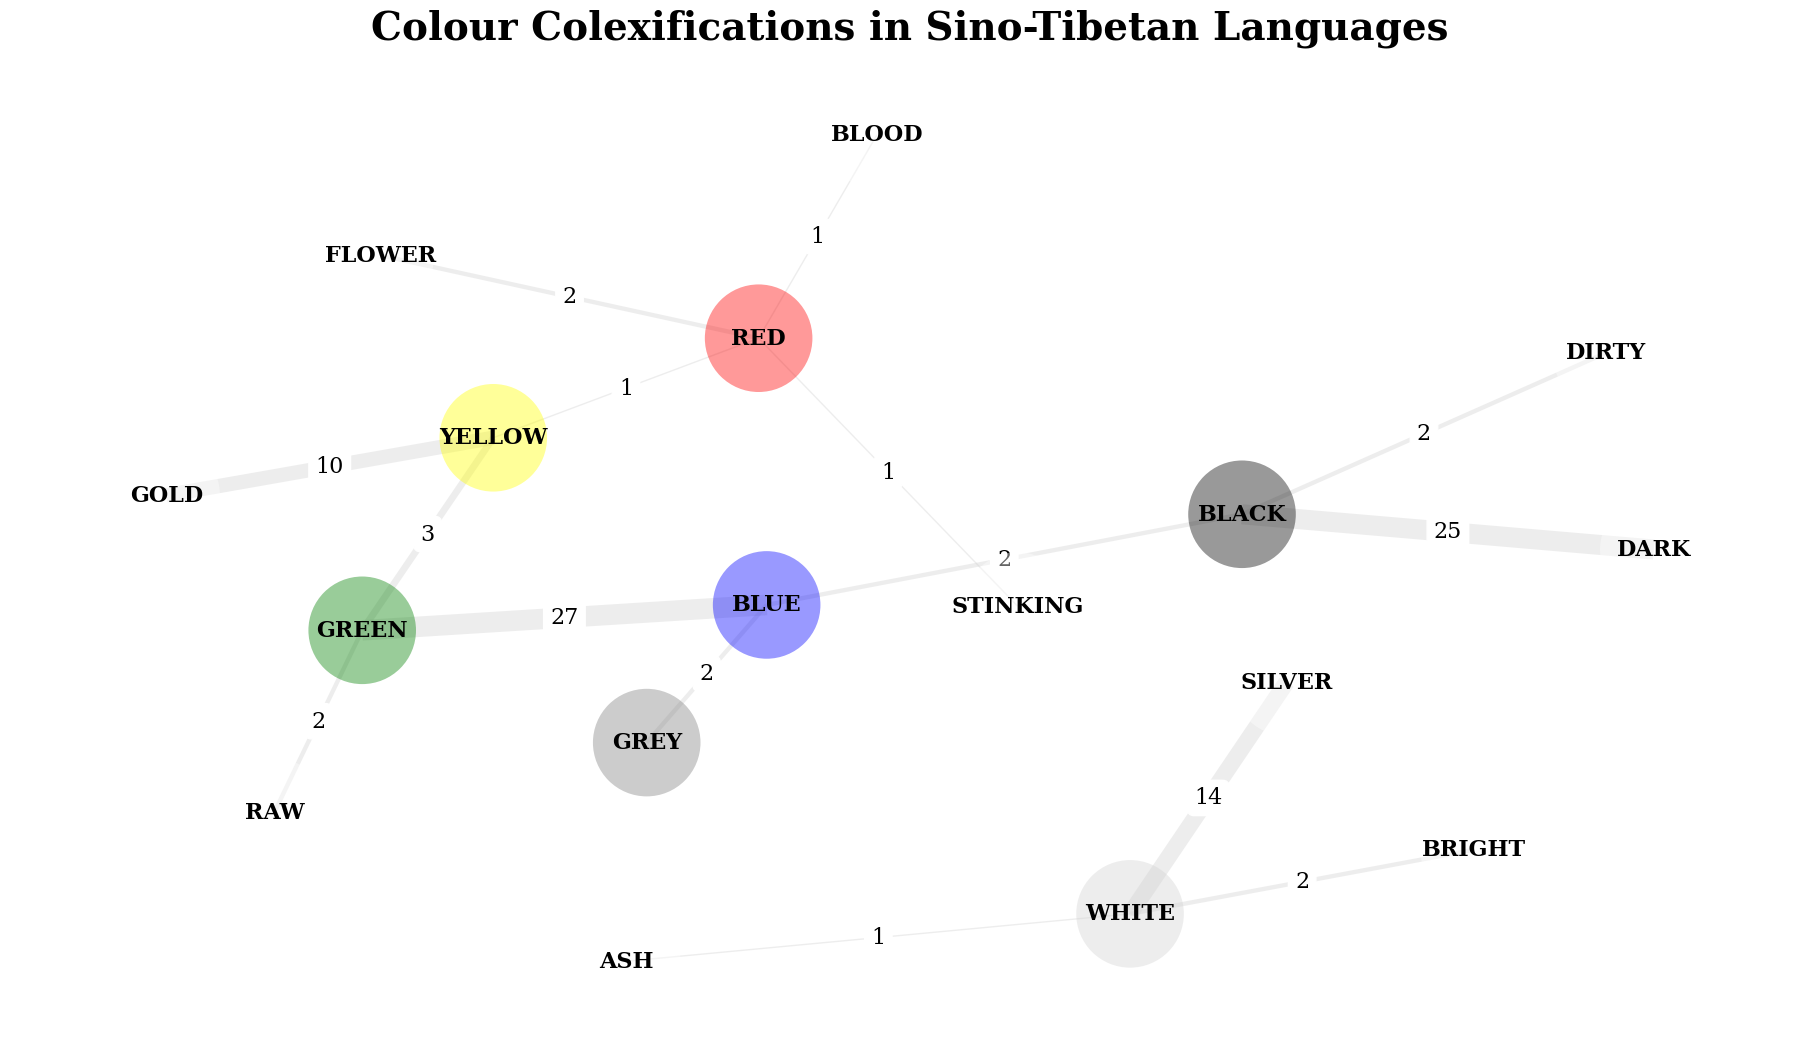

Sino-Tibetan 95 3498


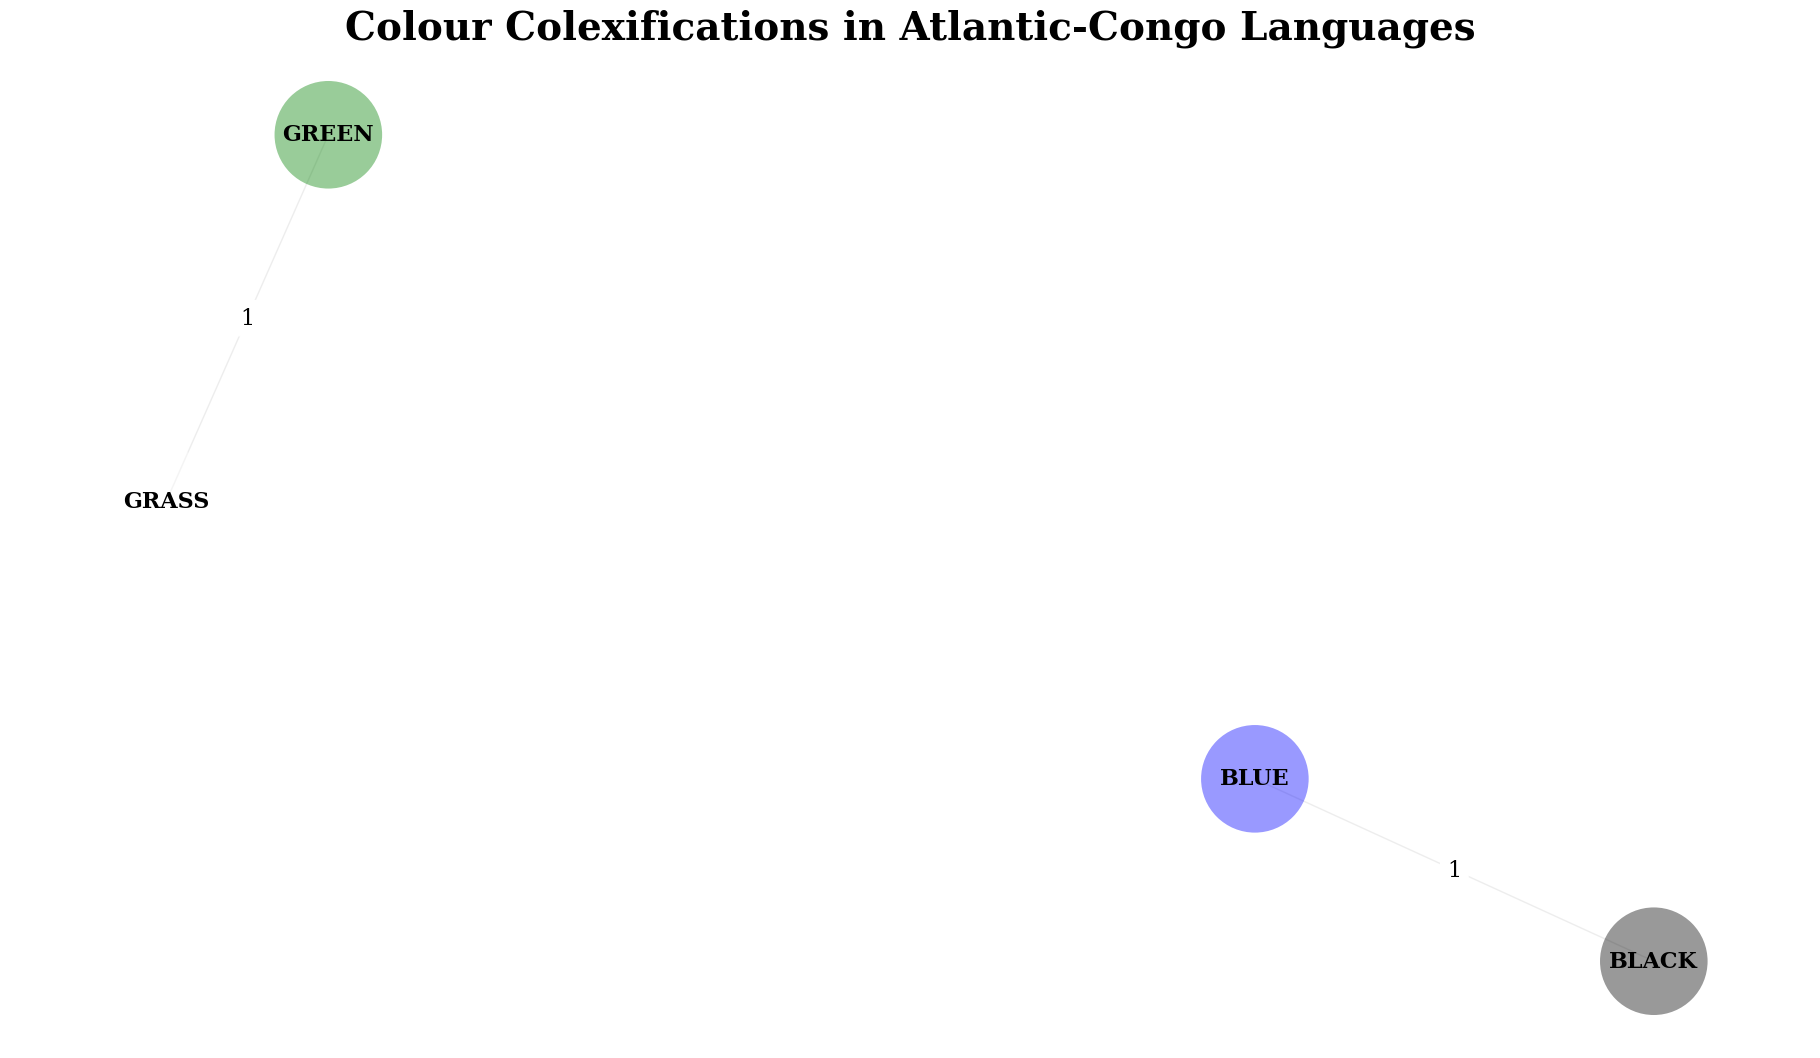

Atlantic-Congo 2 3235


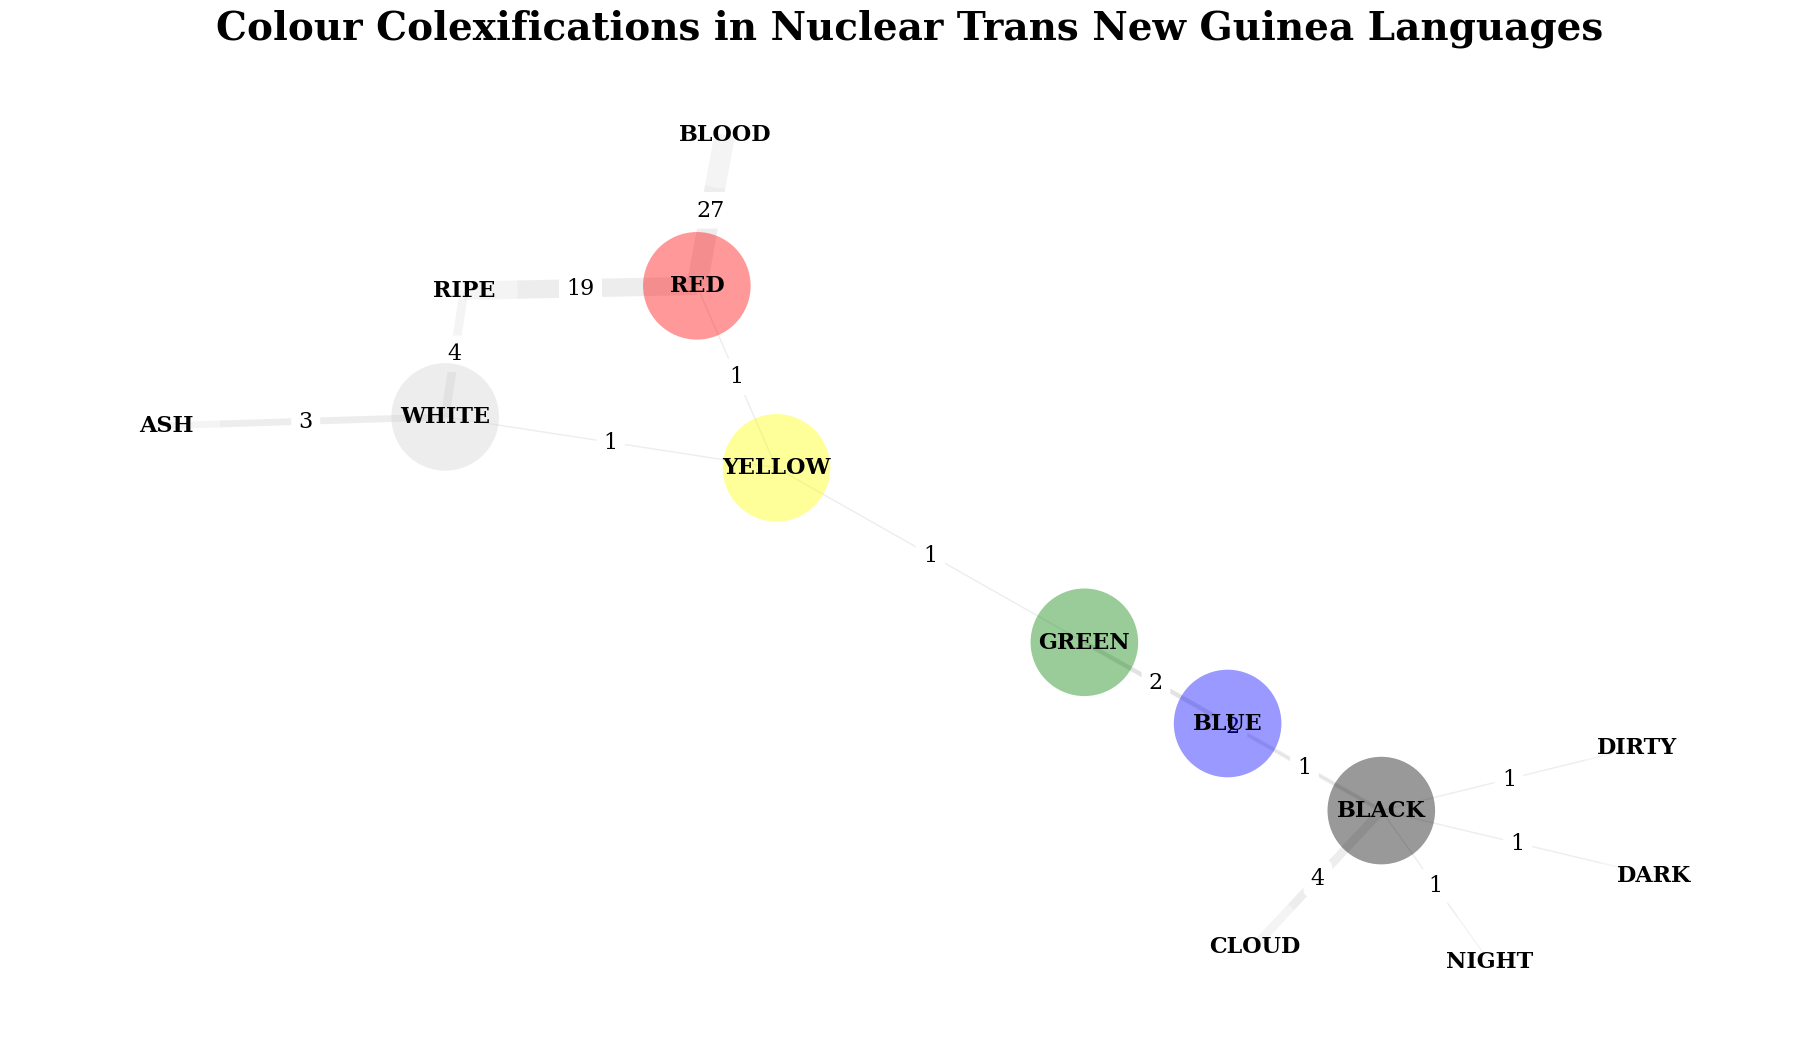

Nuclear Trans New Guinea 68 1950


In [50]:
ratios = {}
for fam in ["Indo-European", "Austronesian", "Nakh-Daghestanian", "Sino-Tibetan", "Atlantic-Congo", "Nuclear Trans New Guinea"]:
    macro = calc_weights(fam, g)
    fw_macro = nx.get_edge_attributes(macro, "FamilyWeight")

    s = graph_by_family(reduced, fam)
    fw = nx.get_edge_attributes(s, "FamilyWeight")

    print(fam, sum(fw.values()), sum(fw_macro.values()))
    ratios[fam] = [sum(fw.values()), sum(fw_macro.values()), round(sum(fw.values()) / sum(fw_macro.values()), 3)]

In [51]:
ratios

{'Indo-European': [84, 9938, 0.008],
 'Austronesian': [87, 4835, 0.018],
 'Nakh-Daghestanian': [41, 12092, 0.003],
 'Sino-Tibetan': [95, 3498, 0.027],
 'Atlantic-Congo': [2, 3235, 0.001],
 'Nuclear Trans New Guinea': [68, 1950, 0.035]}